In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from zipfile import ZipFile
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from google.colab import files
import time
import pandas as pd
np.random.seed(42)
print("Veuillez importer votre fichier kaggle.json")
uploaded = files.upload()
if 'kaggle.json' in uploaded:
    print("Fichier kaggle.json importé avec succès !")
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("Erreur : Le fichier kaggle.json n'a pas été importé.")

Veuillez importer votre fichier kaggle.json


Saving kaggle.json to kaggle.json
Fichier kaggle.json importé avec succès !


In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from zipfile import ZipFile
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
!kaggle datasets download -d benaddym/amazigh-handwritten-character-database-amhcd
with ZipFile('amazigh-handwritten-character-database-amhcd.zip', 'r') as zip_ref:
    zip_ref.extractall('AMHCD')
print("Base de données téléchargée et extraite dans le dossier /AMHCD.")
def load_data_from_char_folders(base_path, img_size=(32, 32)):
    images = []
    labels = []
    possible_paths = [
        os.path.join(base_path, 'AMHCD_64/AMHCD_64'),
        os.path.join(base_path, 'Amazigh handwritten character database (AMHCD)') # Ancien chemin
    ]
    data_path = None
    for path in possible_paths:
        if os.path.exists(path):
            data_path = path
            break
    if data_path is None:
        print(f"ERREUR : Impossible de trouver le dossier de données dans les chemins testés.")
        return None, None
    print(f"Dossier de données trouvé : {data_path}")
    character_folders = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
    label_map = {folder_name: i for i, folder_name in enumerate(character_folders)}
    print(f"Nombre de classes détectées : {len(label_map)}")
    if len(label_map) != 33:
        print(f"ATTENTION : Le nombre de dossiers de caractères détectés ({len(label_map)}) n'est pas 33.")
    for char_folder, label_index in label_map.items():
        folder_path = os.path.join(data_path, char_folder)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            img = cv2.imread(file_path)
            if img is not None:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_resized = cv2.resize(img_gray, img_size)
                img_flattened = img_resized.flatten()
                img_normalized = img_flattened / 255.0
                images.append(img_normalized)
                labels.append(label_index)
    return np.array(images), np.array(labels).reshape(-1, 1)
X_raw, y_raw = load_data_from_char_folders('AMHCD')
if X_raw is None or y_raw is None:
    raise FileNotFoundError("Le chargement des données a échoué. L'exécution est arrêtée.")
else:
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    y = encoder.fit_transform(y_raw)
    print("\nChargement et prétraitement terminés avec succès.")
    print(f"Shape de X (données) : {X_raw.shape}")
    print(f"Shape de y (étiquettes) : {y.shape}")

Dataset URL: https://www.kaggle.com/datasets/benaddym/amazigh-handwritten-character-database-amhcd
License(s): other
  0% 0.00/67.9M [00:00<?, ?B/s]
100% 67.9M/67.9M [00:00<00:00, 1.15GB/s]
Base de données téléchargée et extraite dans le dossier /AMHCD.
Dossier de données trouvé : AMHCD/AMHCD_64/AMHCD_64
Nombre de classes détectées : 33

Chargement et prétraitement terminés avec succès.
Shape de X (données) : (25740, 1024)
Shape de y (étiquettes) : (25740, 33)


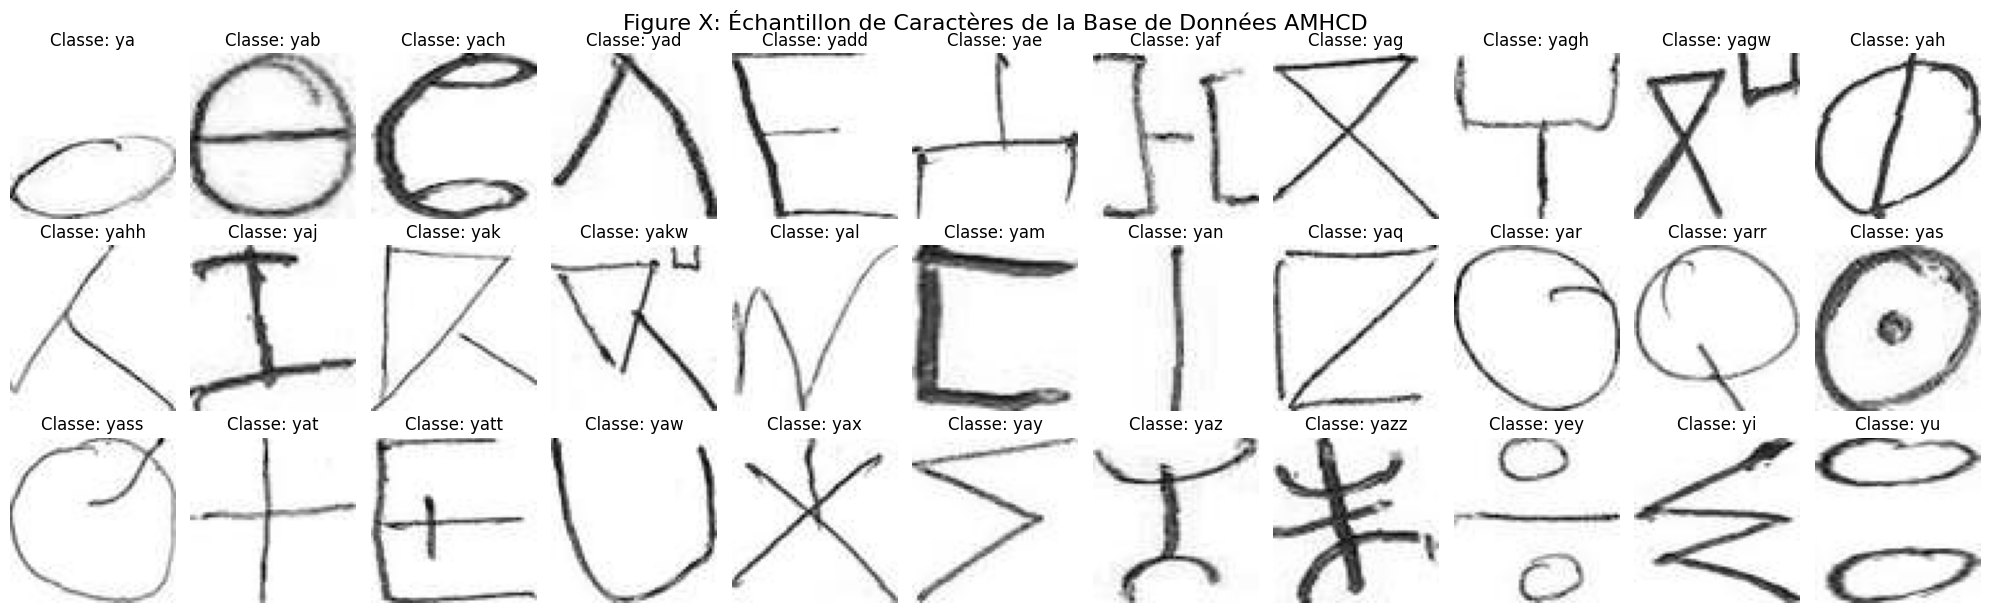

In [ ]:
data_path_fig = 'AMHCD/AMHCD_64/AMHCD_64'
character_folders_fig = sorted([d for d in os.listdir(data_path_fig) if os.path.isdir(os.path.join(data_path_fig, d))])
fig, axes = plt.subplots(3, 11, figsize=(20, 6))
axes = axes.flatten()
for i, folder in enumerate(character_folders_fig):
    img_path = os.path.join(data_path_fig, folder, os.listdir(os.path.join(data_path_fig, folder))[0])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Classe: {folder}')
    axes[i].axis('off')
plt.tight_layout()
plt.suptitle("Figure X: Échantillon de Caractères de la Base de Données AMHCD", fontsize=16, y=1.02)
plt.savefig('amhcd_samples.png', bbox_inches='tight')
plt.show()

In [ ]:
def rotate_image(image, angle):
    image = image.reshape(32, 32)
    h, w = image.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated.flatten()
def translate_image(image, x, y):
    image = image.reshape(32, 32)
    h, w = image.shape
    M = np.float32([[1, 0, x], [0, 1, y]])
    translated = cv2.warpAffine(image, M, (w, h))
    return translated.flatten()
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, lbl in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(lbl)
        rotated_img = rotate_image(img, np.random.uniform(-10, 10))
        augmented_images.append(rotated_img)
        augmented_labels.append(lbl)
        translated_img = translate_image(img, np.random.randint(-2, 3), np.random.randint(-2, 3))
        augmented_images.append(translated_img)
        augmented_labels.append(lbl)
    return np.array(augmented_images), np.array(augmented_labels)

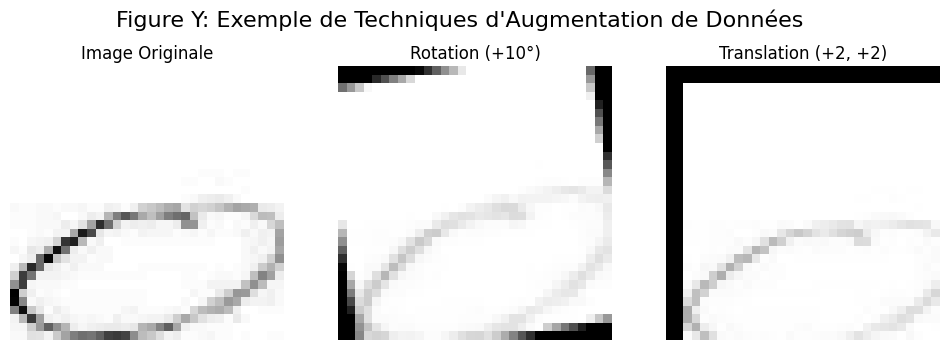

In [ ]:
original_image_vector = X_raw[0]
original_image_matrix = original_image_vector.reshape(32, 32)
rotated_image_vector = rotate_image(original_image_vector, 10) # Rotation de 10 degrés
translated_image_vector = translate_image(original_image_vector, 2, 2) # Translation
rotated_image_matrix = rotated_image_vector.reshape(32, 32)
translated_image_matrix = translated_image_vector.reshape(32, 32)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image_matrix, cmap='gray')
axes[0].set_title('Image Originale')
axes[0].axis('off')
axes[1].imshow(rotated_image_matrix, cmap='gray')
axes[1].set_title('Rotation (+10°)')
axes[1].axis('off')
axes[2].imshow(translated_image_matrix, cmap='gray')
axes[2].set_title('Translation (+2, +2)')
axes[2].axis('off')
plt.suptitle("Figure Y: Exemple de Techniques d'Augmentation de Données", fontsize=16)
plt.savefig('data_augmentation_example.png', bbox_inches='tight')
plt.show()

In [ ]:
def initialize_parameters(layer_dims):
    params = {}
    L = len(layer_dims)
    for l in range(1, L):
        params[f'W{l}'] = np.random.randn(layer_dims[l-1], layer_dims[l]) * np.sqrt(2. / layer_dims[l-1])
        params[f'b{l}'] = np.zeros((1, layer_dims[l]))
    return params
def relu(Z):
    return np.maximum(0, Z)
def relu_derivative(Z):
    return np.where(Z > 0, 1, 0)
def softmax(Z):
    e_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True)) # Stabilité numérique
    return e_Z / np.sum(e_Z, axis=1, keepdims=True)
def forward_propagation(X, params):
    caches = {}
    A = X
    caches['A0'] = X
    L = len(params) // 2
    for l in range(1, L):
        Z = np.dot(A, params[f'W{l}']) + params[f'b{l}'] # Z[l] = A[l-1]W[l] + b[l]
        A = relu(Z) # A[l] = g[l](Z[l])
        caches[f'Z{l}'] = Z
        caches[f'A{l}'] = A
    Z_final = np.dot(A, params[f'W{L}']) + params[f'b{L}']
    A_final = softmax(Z_final)
    caches[f'Z{L}'] = Z_final
    caches[f'A{L}'] = A_final
    return A_final, caches
def compute_cost(A_final, Y, params, lambd):
    m = Y.shape[0]
    cross_entropy_cost = -np.sum(Y * np.log(A_final + 1e-8)) / m
    l2_cost = 0
    L = len(params) // 2
    for l in range(1, L + 1):
        l2_cost += np.sum(np.square(params[f'W{l}']))
    l2_cost = (lambd / (2 * m)) * l2_cost
    total_cost = cross_entropy_cost + l2_cost
    return total_cost
def backward_propagation(A_final, Y, caches, params, lambd):
    grads = {}
    m = Y.shape[0]
    L = len(params) // 2
    dZ = A_final - Y
    A_prev = caches[f'A{L-1}']
    grads[f'dW{L}'] = (np.dot(A_prev.T, dZ) / m) + (lambd / m) * params[f'W{L}']
    grads[f'db{L}'] = np.sum(dZ, axis=0, keepdims=True) / m
    for l in reversed(range(1, L)):
        dA = np.dot(dZ, params[f'W{l+1}'].T)
        dZ = dA * relu_derivative(caches[f'Z{l}'])
        A_prev = caches[f'A{l-1}']
        grads[f'dW{l}'] = (np.dot(A_prev.T, dZ) / m) + (lambd / m) * params[f'W{l}']
        grads[f'db{l}'] = np.sum(dZ, axis=0, keepdims=True) / m
    return grads

In [ ]:
def initialize_adam(params):
    L = len(params) // 2
    v = {}
    s = {}
    for l in range(1, L + 1):
        v[f'dW{l}'] = np.zeros_like(params[f'W{l}'])
        v[f'db{l}'] = np.zeros_like(params[f'b{l}'])
        s[f'dW{l}'] = np.zeros_like(params[f'W{l}'])
        s[f'db{l}'] = np.zeros_like(params[f'b{l}'])
    return v, s
def update_parameters_with_adam(params, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(params) // 2
    v_corrected = {}
    s_corrected = {}
    for l in range(1, L + 1):
        v[f'dW{l}'] = beta1 * v[f'dW{l}'] + (1 - beta1) * grads[f'dW{l}']
        v[f'db{l}'] = beta1 * v[f'db{l}'] + (1 - beta1) * grads[f'db{l}']
        s[f'dW{l}'] = beta2 * s[f'dW{l}'] + (1 - beta2) * np.square(grads[f'dW{l}'])
        s[f'db{l}'] = beta2 * s[f'db{l}'] + (1 - beta2) * np.square(grads[f'db{l}'])
        v_corrected[f'dW{l}'] = v[f'dW{l}'] / (1 - beta1**t)
        v_corrected[f'db{l}'] = v[f'db{l}'] / (1 - beta1**t)
        s_corrected[f'dW{l}'] = s[f'dW{l}'] / (1 - beta2**t)
        s_corrected[f'db{l}'] = s[f'db{l}'] / (1 - beta2**t)
        params[f'W{l}'] -= learning_rate * v_corrected[f'dW{l}'] / (np.sqrt(s_corrected[f'dW{l}']) + epsilon)
        params[f'b{l}'] -= learning_rate * v_corrected[f'db{l}'] / (np.sqrt(s_corrected[f'db{l}']) + epsilon)
    return params, v, s

In [ ]:
def predict(X, params):
    A_final, _ = forward_propagation(X, params)
    return np.argmax(A_final, axis=1)
def calculate_accuracy(y_pred, y_true):
    y_true_labels = np.argmax(y_true, axis=1)
    return np.mean(y_pred == y_true_labels) * 100
def train_model(X_train, y_train, X_val, y_val, layer_dims, epochs, learning_rate, lambd, batch_size=64):
    params = initialize_parameters(layer_dims)
    v, s = initialize_adam(params)
    t = 0
    costs = []
    train_accuracies = []
    val_accuracies = []
    for i in range(epochs):
        epoch_start_time = time.time()
        epoch_cost = 0
        permutation = np.random.permutation(X_train.shape[0])
        shuffled_X = X_train[permutation, :]
        shuffled_Y = y_train[permutation, :]
        for j in range(0, X_train.shape[0], batch_size):
            t += 1
            X_batch = shuffled_X[j:j+batch_size, :]
            Y_batch = shuffled_Y[j:j+batch_size, :]
            A_final, caches = forward_propagation(X_batch, params)
            cost = compute_cost(A_final, Y_batch, params, lambd)
            epoch_cost += cost
            grads = backward_propagation(A_final, Y_batch, caches, params, lambd)
            params, v, s = update_parameters_with_adam(params, grads, v, s, t, learning_rate)
        y_pred_train = predict(X_train, params)
        train_accuracy = calculate_accuracy(y_pred_train, y_train)
        train_accuracies.append(train_accuracy)
        y_pred_val = predict(X_val, params)
        val_accuracy = calculate_accuracy(y_pred_val, y_val)
        val_accuracies.append(val_accuracy)
        avg_epoch_cost = epoch_cost / (X_train.shape[0] / batch_size)
        costs.append(avg_epoch_cost)
        epoch_end_time = time.time()
        print(f"Epoch {i+1}/{epochs} - Cost: {avg_epoch_cost:.4f} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}% - Time: {epoch_end_time - epoch_start_time:.2f}s")
    history = {'costs': costs, 'train_accuracies': train_accuracies, 'val_accuracies': val_accuracies}
    return params, history

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


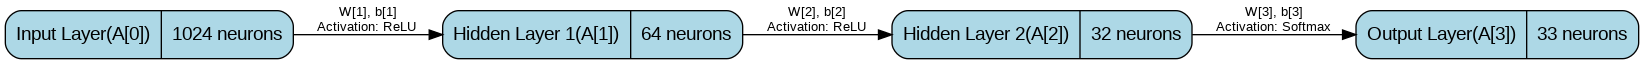

In [ ]:
!pip install graphviz
!apt-get install -y graphviz
from graphviz import Digraph
dot = Digraph(comment='MLP Architecture')
dot.attr(rankdir='LR', splines='line', nodesep='0.8')
dot.attr('node', shape='record', style='rounded,filled', fillcolor='lightblue', fontname='Helvetica')
dot.attr('edge', fontname='Helvetica', fontsize='10')
layers = [
    ('Input Layer\n(A[0])', 1024),
    ('Hidden Layer 1\n(A[1])', 64),
    ('Hidden Layer 2\n(A[2])', 32),
    ('Output Layer\n(A[3])', 33)
]
for i, (name, size) in enumerate(layers):
    dot.node(f'layer_{i}', f'{{{name}|{size} neurons}}')
for i in range(len(layers) - 1):
    if i < len(layers) - 2:
        activation = 'ReLU'
    else:
        activation = 'Softmax'
    dot.edge(f'layer_{i}', f'layer_{i+1}', label=f'W[{i+1}], b[{i+1}]\nActivation: {activation}')
try:
    dot.render('mlp_architecture', format='png', view=False, cleanup=True)
    from IPython.display import Image
    display(Image(filename='mlp_architecture.png'))
except Exception as e:
    print(f"Une erreur est survenue")

In [ ]:
LAYER_DIMS = [X_raw.shape[1], 64, 32, y.shape[1]]
EPOCHS = 50
LEARNING_RATE = 0.001 # Un bon point de départ pour Adam
LAMBDA = 0.01 # Hyperparamètre de régularisation L2
BATCH_SIZE = 128
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42, stratify=y_raw)
print("Application de l'augmentation des données sur le set d'entraînement...")
X_train_aug, y_train_aug = augment_data(X_train, y_train)
print(f"Taille du set d'entraînement avant augmentation : {X_train.shape[0]}")
print(f"Taille du set d'entraînement après augmentation : {X_train_aug.shape[0]}")
print("\nLancement de l'entraînement du modèle...")
trained_params, history = train_model(
    X_train_aug, y_train_aug,
    X_test, y_test,         # Utilisation du set de test comme set de validation ici
    layer_dims=LAYER_DIMS,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    lambd=LAMBDA,
    batch_size=BATCH_SIZE
)
y_pred_test = predict(X_test, trained_params)
test_accuracy = calculate_accuracy(y_pred_test, y_test)
print(f"\nPrécision finale sur le set de test : {test_accuracy:.2f}%")

Application de l'augmentation des données sur le set d'entraînement...
Taille du set d'entraînement avant augmentation : 20592
Taille du set d'entraînement après augmentation : 61776

Lancement de l'entraînement du modèle...
Epoch 1/50 - Cost: 3.2051 - Train Acc: 20.88% - Val Acc: 23.02% - Time: 3.09s
Epoch 2/50 - Cost: 2.5158 - Train Acc: 35.79% - Val Acc: 41.16% - Time: 3.12s
Epoch 3/50 - Cost: 2.1198 - Train Acc: 43.33% - Val Acc: 47.11% - Time: 5.44s
Epoch 4/50 - Cost: 1.8791 - Train Acc: 49.18% - Val Acc: 54.04% - Time: 3.35s
Epoch 5/50 - Cost: 1.7270 - Train Acc: 52.03% - Val Acc: 56.25% - Time: 12.08s
Epoch 6/50 - Cost: 1.6270 - Train Acc: 52.32% - Val Acc: 56.55% - Time: 12.71s
Epoch 7/50 - Cost: 1.5662 - Train Acc: 56.53% - Val Acc: 61.58% - Time: 14.39s
Epoch 8/50 - Cost: 1.5238 - Train Acc: 56.21% - Val Acc: 61.01% - Time: 4.30s
Epoch 9/50 - Cost: 1.4993 - Train Acc: 58.45% - Val Acc: 62.72% - Time: 3.03s
Epoch 10/50 - Cost: 1.4655 - Train Acc: 57.89% - Val Acc: 62.33% - Tim

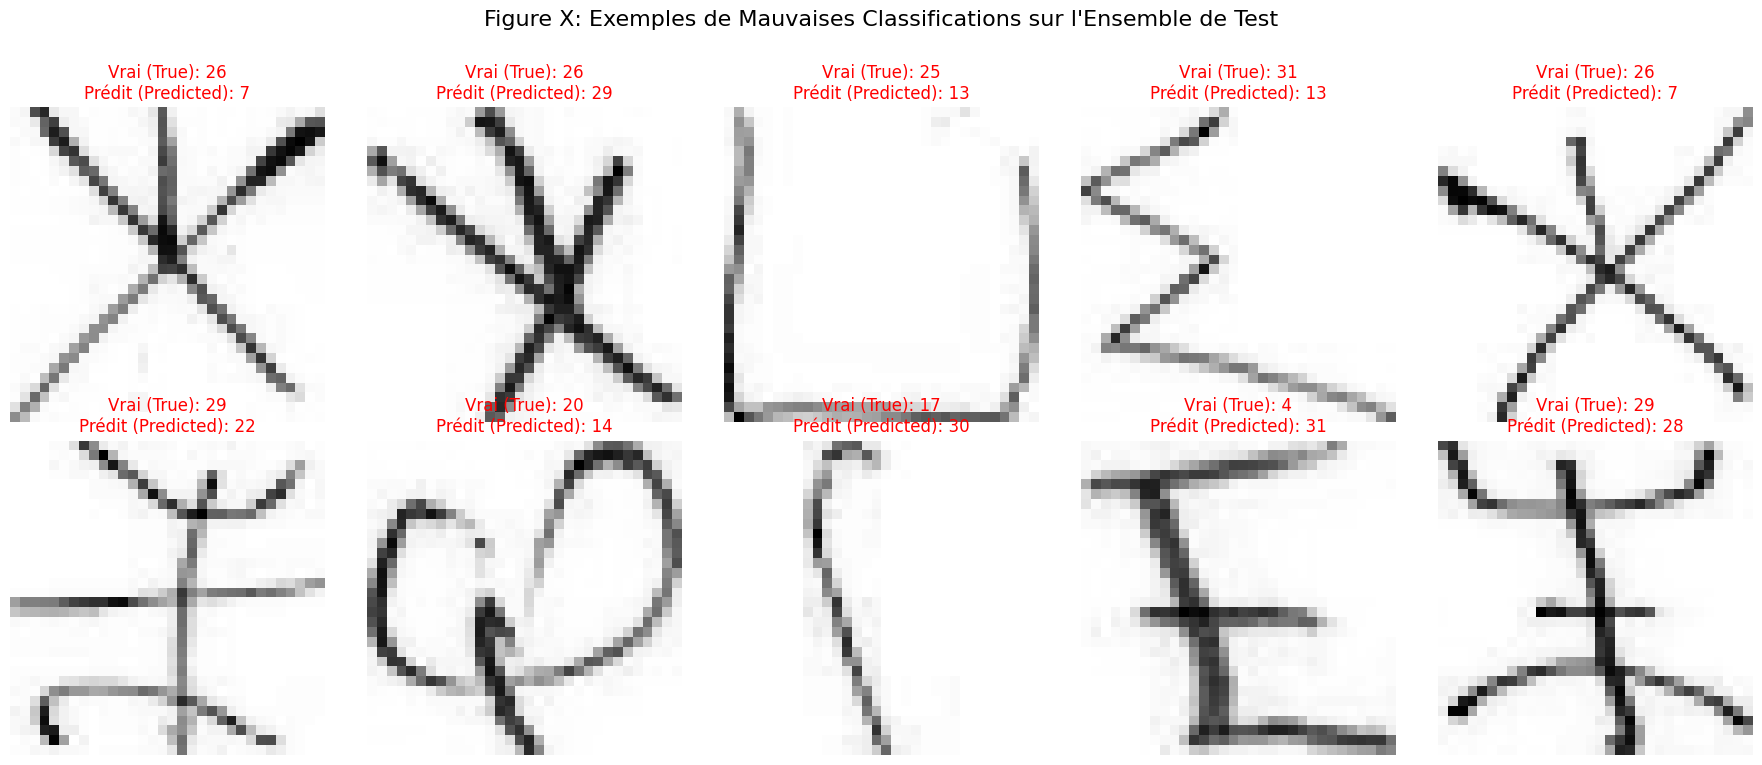

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
y_test_labels = np.argmax(y_test, axis=1)
misclassified_indices = np.where(y_pred_test != y_test_labels)[0]
if len(misclassified_indices) > 10:
    random_indices = np.random.choice(misclassified_indices, size=10, replace=False)
else:
    random_indices = misclassified_indices
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()
for i, idx in enumerate(random_indices):
    image = X_test[idx].reshape(32, 32)
    true_label = y_test_labels[idx]
    pred_label = y_pred_test[idx]
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Vrai (True): {true_label}\nPrédit (Predicted): {pred_label}", color='red')
    axes[i].axis('off')
fig.suptitle("Figure X: Exemples de Mauvaises Classifications sur l'Ensemble de Test", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuster pour le titre principal
plt.savefig('misclassified_examples.png')
plt.show()

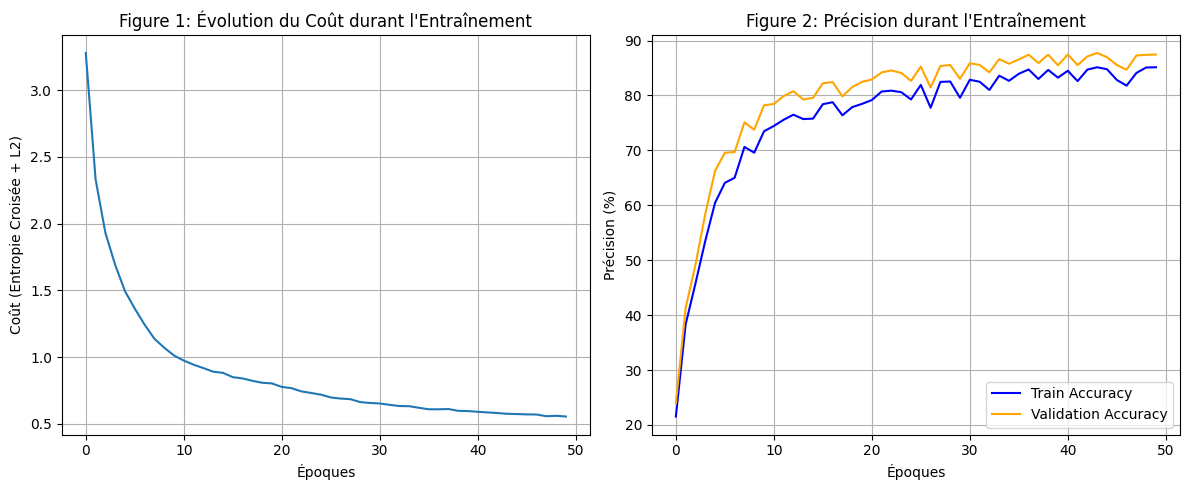

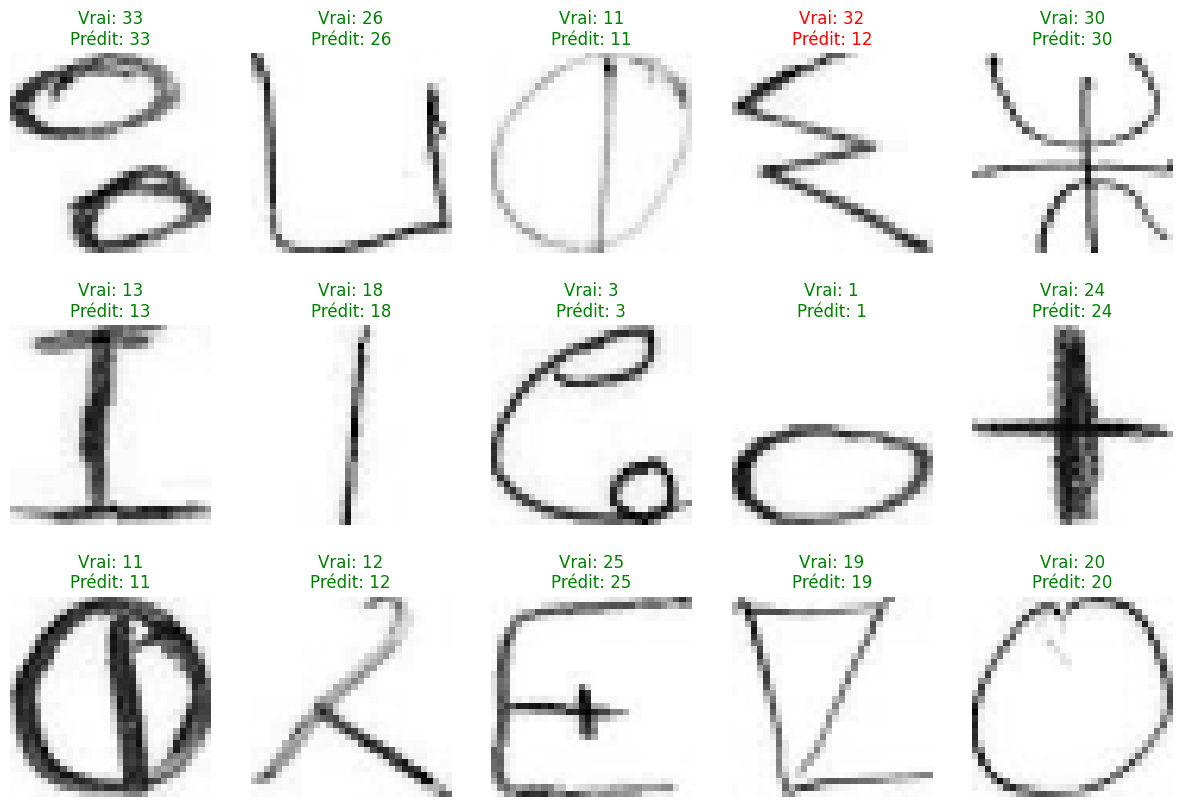

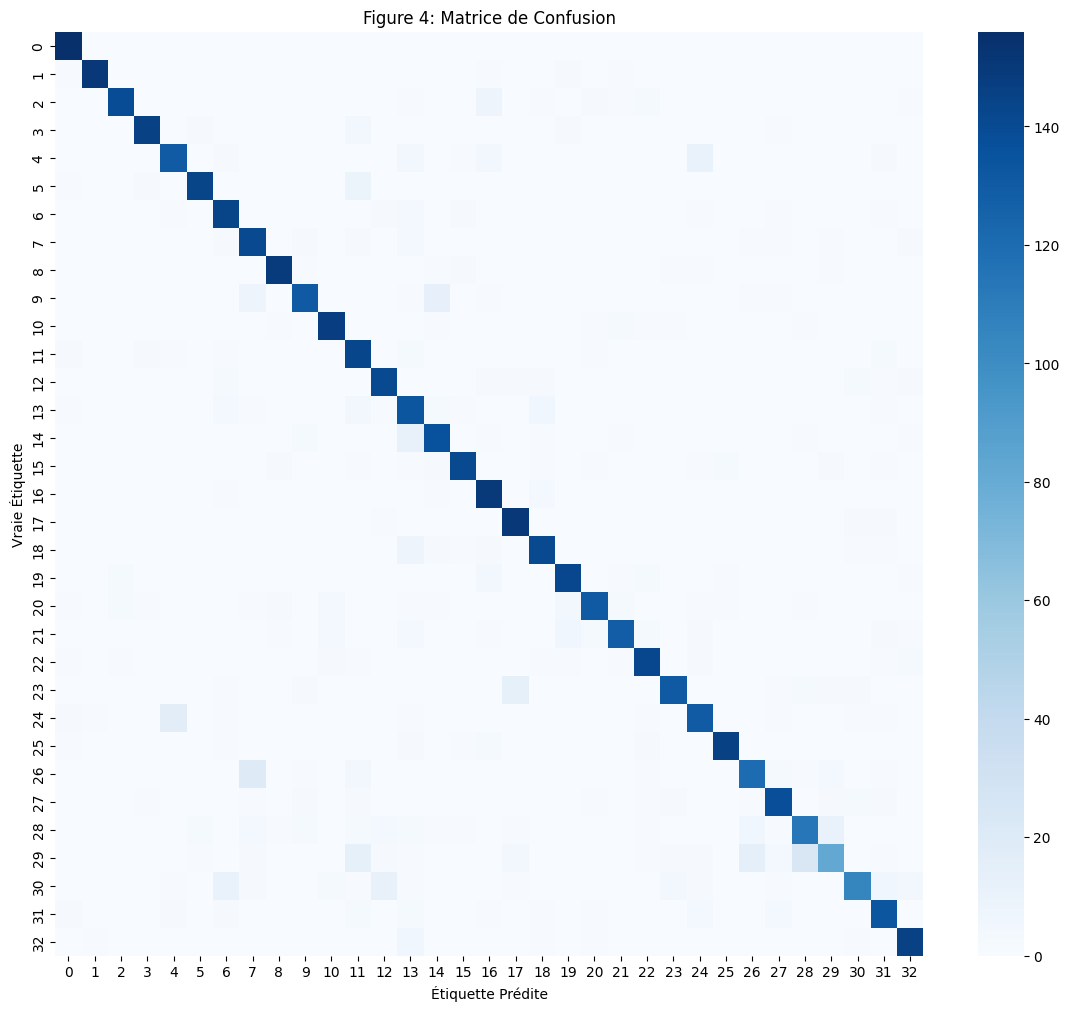

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['costs'])
plt.title("Figure 1: Évolution du Coût durant l'Entraînement")
plt.xlabel("Époques")
plt.ylabel("Coût (Entropie Croisée + L2)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracies'], color='blue', label='Train Accuracy')
plt.plot(history['val_accuracies'], color='orange', label='Validation Accuracy')
plt.title("Figure 2: Précision durant l'Entraînement")
plt.xlabel("Époques")
plt.ylabel("Précision (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
y_test_labels = np.argmax(y_test, axis=1)
for i in range(15):
    idx = np.random.randint(0, X_test.shape[0])
    image = X_test[idx].reshape(32, 32)
    true_label = y_test_labels[idx]
    pred_label = y_pred_test[idx]

    plt.subplot(3, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Vrai: {true_label+1}\nPrédit: {pred_label+1}",
              color='green' if true_label == pred_label else 'red')
    plt.axis('off')
plt.show()


from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test_labels, y_pred_test)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Figure 4: Matrice de Confusion')
plt.ylabel('Vraie Étiquette')
plt.xlabel('Étiquette Prédite')
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
print("\n--- Lancement de la Validation Croisée K-Fold Stratifiée ---")
X = X_raw
y_labels_for_split = y_raw.flatten()
n_splits = 5 # Nombre de "folds"
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_accuracies = []
fold_histories = []
fold_num = 1
K_FOLD_EPOCHS = 25
for train_index, val_index in skf.split(X, y_labels_for_split):
    print(f"\n--- Fold {fold_num}/{n_splits} ---")
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    X_train_fold_aug, y_train_fold_aug = augment_data(X_train_fold, y_train_fold)
    params_fold, history_fold = train_model(
        X_train_fold_aug, y_train_fold_aug,
        X_val_fold, y_val_fold,
        layer_dims=LAYER_DIMS,
        epochs=K_FOLD_EPOCHS,
        learning_rate=LEARNING_RATE,
        lambd=LAMBDA,
        batch_size=BATCH_SIZE
    )
    y_pred_fold = predict(X_val_fold, params_fold)
    accuracy_fold = calculate_accuracy(y_pred_fold, y_val_fold)
    fold_accuracies.append(accuracy_fold)
    fold_histories.append(history_fold)
    print(f"--- Précision pour le Fold {fold_num}: {accuracy_fold:.2f}% ---")
    fold_num += 1
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
results_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(n_splits)],
    'Précision (%)': fold_accuracies
})

print("\n--- Tableau 2: Résultats de la Validation Croisée ---")
print(results_df)
print(f"\nPrécision Moyenne sur {n_splits} Folds: {mean_accuracy:.2f}%")
print(f"Écart-Type de la Précision: {std_accuracy:.2f}%")


--- Lancement de la Validation Croisée K-Fold Stratifiée ---

--- Fold 1/5 ---
Epoch 1/25 - Cost: 3.2044 - Train Acc: 20.44% - Val Acc: 22.01% - Time: 6.23s
Epoch 2/25 - Cost: 2.2996 - Train Acc: 43.94% - Val Acc: 50.02% - Time: 3.83s
Epoch 3/25 - Cost: 1.7446 - Train Acc: 55.63% - Val Acc: 61.03% - Time: 3.48s
Epoch 4/25 - Cost: 1.5095 - Train Acc: 60.78% - Val Acc: 67.04% - Time: 6.22s
Epoch 5/25 - Cost: 1.3555 - Train Acc: 65.09% - Val Acc: 71.60% - Time: 3.38s
Epoch 6/25 - Cost: 1.2290 - Train Acc: 62.51% - Val Acc: 68.12% - Time: 3.41s
Epoch 7/25 - Cost: 1.1431 - Train Acc: 70.93% - Val Acc: 75.85% - Time: 6.18s
Epoch 8/25 - Cost: 1.0595 - Train Acc: 71.11% - Val Acc: 76.46% - Time: 3.46s
Epoch 9/25 - Cost: 1.0102 - Train Acc: 72.41% - Val Acc: 77.60% - Time: 3.51s
Epoch 10/25 - Cost: 0.9730 - Train Acc: 75.86% - Val Acc: 81.14% - Time: 6.30s
Epoch 11/25 - Cost: 0.9387 - Train Acc: 76.32% - Val Acc: 81.90% - Time: 3.42s
Epoch 12/25 - Cost: 0.9099 - Train Acc: 75.73% - Val Acc: 80